# Example script to show gyre layer transects

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm

In [2]:
session=cc.database.create_session()

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43351,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:38113,Total threads: 4
Dashboard: /proxy/44291/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:33243,


In [4]:
expt = 'panant-01-hycom1'

In [5]:
# time period
start_time = '1995-01-01'
end_time = '2000-01-01'

### Load zonal transport and layer thickness in density space

In [6]:
umo = cc.querying.getvar(expt,'umo', session, start_time=start_time, end_time=end_time).sel(time = slice(start_time,end_time)).mean('time')
hmo = cc.querying.getvar(expt,'hmo',session,start_time=start_time, end_time=end_time).sel(time = slice(start_time,end_time)).mean('time')

### Select interface density dividing upper and lower ocean

In [35]:
rho2_0 =1037.15

### Calculate upper & lower layer streamfunctions and depths

In [39]:
flux1 = (umo.cumsum('yh').sel(rho2_l=slice(1000,rho2_0)).sum('rho2_l')/1e9).load()
flux2 = (umo.cumsum('yh').sel(rho2_l=slice(rho2_0,1038.0)).sum('rho2_l')/1e9).load()
h1 = hmo.sel(rho2_l=slice(1000,rho2_0)).sum('rho2_l').load()
h2 = hmo.sel(rho2_l=slice(rho2_0,1038.0)).sum('rho2_l').load()

### Quick plot of streamfunctions for this choice of interface

Text(0, 0.5, '')

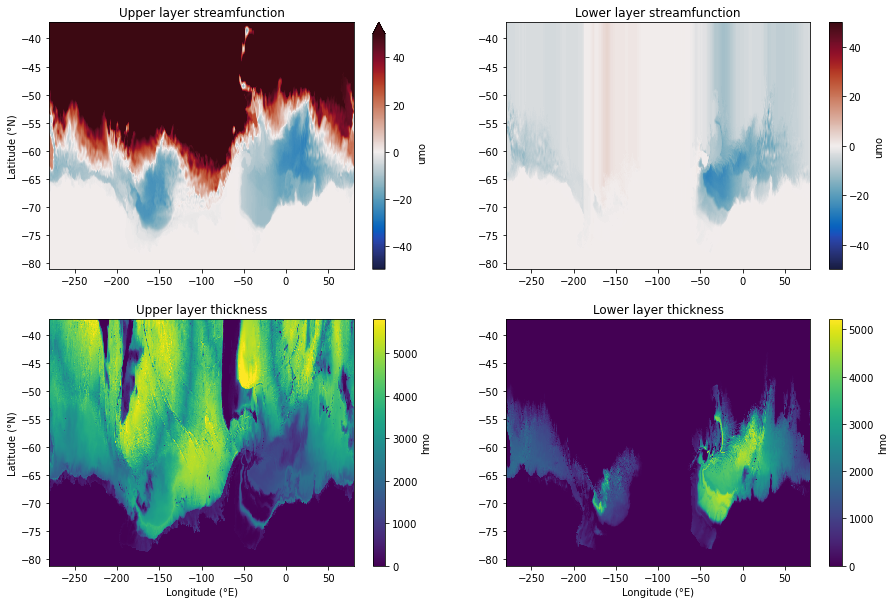

In [158]:
plt.figure(figsize=(15,10))
plt.subplot(221)
flux1.plot(vmin=-50,vmax=50,cmap=cm.cm.balance)
plt.title('Upper layer streamfunction')
plt.xlabel('')
plt.ylabel('Latitude (°N)')
plt.subplot(222)
flux2.plot(vmin=-50,vmax=50,cmap=cm.cm.balance)
plt.title('Lower layer streamfunction')
plt.xlabel('')
plt.ylabel('')
plt.subplot(223)
h1.plot()
plt.title('Upper layer thickness')
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')
plt.subplot(224)
h2.plot()
plt.title('Lower layer thickness')
plt.xlabel('Longitude (°E)')
plt.ylabel('')

### Now, select a transect, and plot layerwise streamfunctions on that transect

In [172]:
xval=20
depth = np.stack([0.0*h1.sel(xh=xval,method='nearest').values,
                  h1.sel(xh=xval,method='nearest').values,
                  (h1+h2).sel(xh=xval,method='nearest').values])
fluxes = np.stack([flux1.sel(xq=xval,method='nearest').values,
                   flux2.sel(xq=xval,method='nearest').values])

Text(0.5, 0, 'Latitude (°N)')

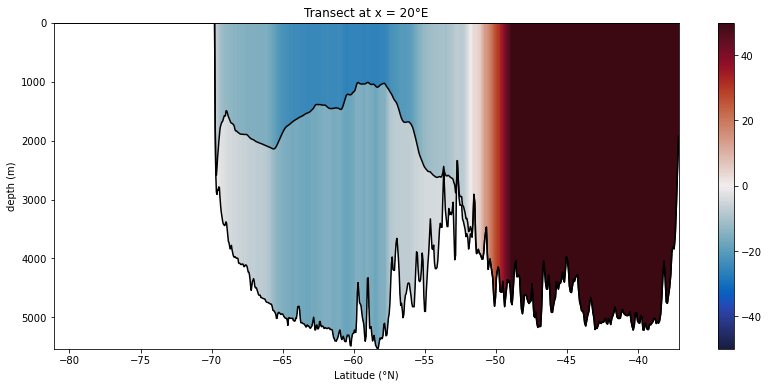

In [173]:
plt.figure(figsize=(14,6))
plt.pcolor(flux1.yh.values,depth,fluxes[:,1:],shading='flat',vmin=-50,vmax=50,cmap=cm.cm.balance)
for ii in range(3):
    plt.plot(flux1.yh.values,depth[ii,:],'k')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('Transect at x = %d°E'%xval)
plt.ylabel('depth (m)')
plt.xlabel('Latitude (°N)')